<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 2*
# Convolutional Neural Networks (CNNs)

# Assignment

Load a pretrained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

ResNet50 = ResNet50(weights='imagenet')
features = model.predict(x)

```

Next you will need to remove the last layer from the ResNet model. Here, we loop over the layers to use the sequential API. There are easier ways to add and remove layers using the Keras functional API, but doing so introduces other complexities. 

```python
# Remote the Last Layer of ResNEt
ResNet50._layers.pop(0)

# Out New Model
model = Sequential()

# Add Pre-trained layers of Old Model to New Model
for layer in ResNet50.layers:
    model.add(layer)

# Turn off additional training of ResNet Layers for speed of assignment
for layer in model.layers:
    layer.trainable = False

# Add New Output Layer to Model
model.add(Dense(1, activation='sigmoid'))
```

Your assignment is to apply the transfer learning above to classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

Steps to complete assignment: 
1. Load in Image Data into numpy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pretrained layers from resnet
4. Report your model's accuracy

In [6]:
!pip install --upgrade scikit-image

Requirement already up-to-date: scikit-image in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (0.15.0)
Requirement not upgraded as not directly required: matplotlib!=3.0.0,>=2.0.0 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (3.0.3)
Requirement not upgraded as not directly required: pillow>=4.3.0 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (5.2.0)
Requirement not upgraded as not directly required: imageio>=2.0.1 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (2.3.0)
Requirement not upgraded as not directly required: PyWavelets>=0.4.0 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (0.5.2)
Requirement not upgraded as not directly required: scipy>=0.17.0 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (1.3.0)
Requirem

In [2]:
!pip install tensorflow-hub

    100% |████████████████████████████████| 92kB 4.0MB/s ta 0:00:011
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

import imageio
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from skimage import color, io
from skimage.exposure import rescale_intensity
import tensorflow as tf
import tensorflow_hub as hub

In [13]:
mimages = io.imread_collection('./data/mountain/*')
fimages = io.imread_collection('./data/forest/*')

In [14]:
print(len(mimages), len(fimages))

374 328


In [15]:
def greyscale_images(images):
    grayscale_images = []
    for img in images:
        gs_image = rescale_intensity(color.rgb2gray(img))
        grayscale_images.append(gs_image)
    return grayscale_images    

In [16]:
mountain_grayscale = greyscale_images(mimages)
print("Number of images(Mountains):",len(mountain_grayscale),"\nExample Array:\n", mountain_grayscale[0])

forest_grayscale = greyscale_images(fimages)
print("\nNumber of images(Forest):",len(forest_grayscale),"\nExample Array:\n", forest_grayscale[0])

Number of images(Mountains): 374 
Example Array:
 [[1.48976471e-02 7.99650980e-02 2.17570196e-01 ... 2.52999216e-01
  2.54665882e-01 2.59688627e-01]
 [1.79858824e-02 5.25141176e-02 2.04138824e-01 ... 2.28949020e-01
  2.28666275e-01 2.23873725e-01]
 [1.85513725e-02 5.08474510e-02 2.33026275e-01 ... 2.28160392e-01
  2.28428235e-01 2.28145490e-01]
 ...
 [8.33333333e-04 1.45098039e-01 9.96078431e-01 ... 6.87389804e-01
  7.03076078e-01 7.00553333e-01]
 [8.33333333e-04 1.45098039e-01 9.96078431e-01 ... 6.87389804e-01
  6.87389804e-01 6.89927451e-01]
 [8.33333333e-04 1.39204314e-01 9.96078431e-01 ... 6.86824314e-01
  6.73958431e-01 6.86005882e-01]]

Number of images(Forest): 328 
Example Array:
 [[0.00257383 0.00717807 0.00514767 ... 0.00291096 0.04328482 0.00261986]
 [0.00257383 0.00918505 0.00686356 ... 0.04904617 0.01674708 0.00463492]
 [0.00428972 0.01060985 0.00857945 ... 0.00376163 0.00058219 0.01673174]
 ...
 [0.00200698 0.04641823 0.01815653 ... 0.02645295 0.0097519  0.01810243]
 [0.0

In [17]:
print(mountain_grayscale[10].shape)
print(forest_grayscale[10].shape)

(256, 256)
(256, 256)


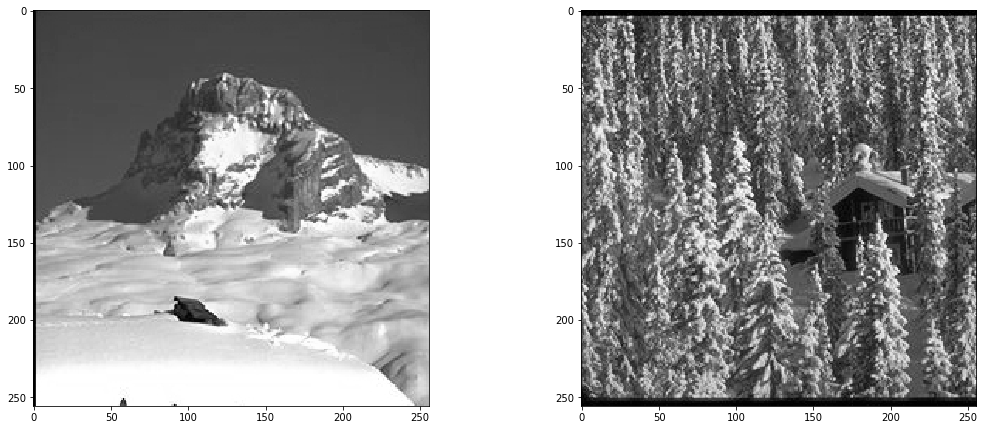

In [18]:
fig = plt.figure(figsize=(18, 16))

plt.subplot(2, 2, 1)
plt.imshow(mountain_grayscale[0], cmap="gray");

plt.subplot(2, 2, 2)
plt.imshow(forest_grayscale[0], cmap="gray");

In [21]:
from keras.models import Sequential
import tensorflow

# Out New Model
model = tensorflow.keras.Sequential()

ResNet50 = ResNet50(input_shape=(256, 256), weights='imagenet')

TypeError: __call__() missing 1 required positional argument: 'inputs'

In [20]:
# Add Pre-trained layers of Old Model to New Model
for layer in ResNet50.layers:
    model.add(layer)

# Turn off additional training of ResNet Layers for speed of assignment
for layer in model.layers:
    layer.trainable = False

# Add New Output Layer to Model
model.add(Dense(1, activation='sigmoid'))

ValueError: Input 0 of layer res2a_branch1 is incompatible with the layer: expected axis -1 of input shape to have value 64 but received input with shape [None, 56, 56, 256]

In [ ]:
features = model.predict(x)

# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g. download images of parties, recognize all that contain balloons)
- Check out [other available pretrained networks](https://tfhub.dev), try some and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g. [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed in to your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution based object detection system, focused on inference speed (for applications to e.g. self driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language